# TITANIC: Kaggle competition

**TAREA: CLASIFICACIÓN**<br>
**NIVEL: INTERMEDIATE**

Vamos a participar en la competicion de **Kaggle del Titanic**: https://www.kaggle.com/competitions/titanic <br> Para ello atacaremos 3 puntos clave para obtener el mejor modelo posible:
* ML Preprocessing
* Competicion de modelos
* Hiperparametros
<br><br>
A diferencia de en el flujo ML convencional, en las competiciones de Kaggle no haremos la evaluación del TEST en el notebook, sino que tendremos que subir un predict del test a la plataforma de submissions y la plataforma lo evaluará.
<br><br>
...A POR ELLO!

# Librerias

In [143]:
import pandas as pd     # Manejo de dataframes
import numpy as np      # Calculos matriciales
import matplotlib.pyplot as plt    # Visualizacion
import seaborn as sns              # Visualizacion
pd.set_option('display.max_columns', None)   # para visualizar mas columnas en un df

import warnings
warnings.filterwarnings("ignore")  # inhabilita warnings

In [144]:
from sklearn.feature_selection import VarianceThreshold   # para obtener la varianza
from sklearn.preprocessing import StandardScaler          #escalar variables numericas
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV    #usar parametros aleatorios para la Hiperparametrizacion (HP)

#Modelos de clasificacion
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

# Funciones

In [145]:
# Funcion que calcula el AUC de un modelo sobre un dataset (X-y). Args: modelo a validar, X, y
def auc(model,X,y):
  model.fit(X,y)
  return roc_auc_score(y,model.predict_proba(X)[:,1])

# Funcion que calcula el AUC en Cross-Validation (X-y). Args: modelo a validar, X, y
def auc_cross_validation(model,X,y):
  cross_val = cross_val_score(model,
                              X, y,
                              cv=4,                 # Numero de folds que vamos a utilizar para validar
                              scoring='roc_auc'     # La metrica de validacion que se medira en cada train-valida
                              )
  return cross_val.mean()

In [146]:
# Inicializa resultados
label_, auc_train_ , auc_valida_ = [], [], []

# Completa un registro en dataframe con los resultados de las funciones definidas previsamente ( AUC y AUC con cross-validation)

# Inputs:
#   * modelo
#   * (X,y)
#   * label especifico si queremos registrar el resultado con otro nombre (opcional)


def evaluate_classification(model, X, y, label=None):
  if label is None:
    label=str(model)
  label_.append(label)

  auc_train = auc(model,X,y)
  auc_valida = auc_cross_validation(model,X,y)
  auc_train_.append(auc_train)
  auc_valida_.append(auc_valida)

  return pd.DataFrame({'Model': label_,
                      'AUC Train': auc_train_,
                      'AUC Cross-Valida': auc_valida_
                      }).sort_values('AUC Cross-Valida',ascending=False)

# Load dataset

In [147]:
df = pd.read_csv('titanic/train.csv')

In [148]:
print(df.shape)

(891, 12)


In [149]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [150]:
# Primera letra cabina
df['Cabin_letter'] = df['Cabin'].str[0]

In [151]:
df['Cabin_letter'].value_counts()

Cabin_letter
C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: count, dtype: int64

In [152]:
map_values = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
    'T': 20
}

df['Cabin_letter'] = df['Cabin_letter'].map(map_values)

In [153]:
# Longitud nombre
df["largoname"]=df['Name'].str.len()

In [154]:
# Numero de palabras
df["palabrasname"]=df["Name"].apply(lambda n: len(n.split()))

# ML Preprocessing

## Data cleaning

El step del data cleaning es el cajón de sastre donde corregiremos las particularidades del dataset más allá del ML preprocessing estandar. Por ejemplo:
* Eliminar registros duplicados
* Eliminar filas sin target informado
* Eliminar columnas irrelevantes
* Corregir erratas en literales
* Corregir data types

In [155]:
df[df.duplicated(keep=False)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_letter,largoname,palabrasname


In [156]:
del(df["PassengerId"])

In [157]:
df.isnull().sum()

Survived          0
Pclass            0
Name              0
Sex               0
Age             177
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           687
Embarked          2
Cabin_letter    687
largoname         0
palabrasname      0
dtype: int64

In [158]:
for i in df:
  if df[i].dtype.kind == "O":
      print(i,df[i].unique(),"\n")

Name ['Braund, Mr. Owen Harris'
 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)'
 'Heikkinen, Miss. Laina' 'Futrelle, Mrs. Jacques Heath (Lily May Peel)'
 'Allen, Mr. William Henry' 'Moran, Mr. James' 'McCarthy, Mr. Timothy J'
 'Palsson, Master. Gosta Leonard'
 'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)'
 'Nasser, Mrs. Nicholas (Adele Achem)' 'Sandstrom, Miss. Marguerite Rut'
 'Bonnell, Miss. Elizabeth' 'Saundercock, Mr. William Henry'
 'Andersson, Mr. Anders Johan' 'Vestrom, Miss. Hulda Amanda Adolfina'
 'Hewlett, Mrs. (Mary D Kingcome) ' 'Rice, Master. Eugene'
 'Williams, Mr. Charles Eugene'
 'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)'
 'Masselmani, Mrs. Fatima' 'Fynney, Mr. Joseph J' 'Beesley, Mr. Lawrence'
 'McGowan, Miss. Anna "Annie"' 'Sloper, Mr. William Thompson'
 'Palsson, Miss. Torborg Danira'
 'Asplund, Mrs. Carl Oscar (Selma Augusta Emilia Johansson)'
 'Emir, Mr. Farred Chehab' 'Fortune, Mr. Charles Alexander'
 'O\'Dwyer, Miss. Ellen "Nellie"' 'T

In [159]:
del(df["Cabin"])

In [160]:
del(df["Ticket"])

In [161]:
del(df["Name"])

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int64  
 1   Pclass        891 non-null    int64  
 2   Sex           891 non-null    object 
 3   Age           714 non-null    float64
 4   SibSp         891 non-null    int64  
 5   Parch         891 non-null    int64  
 6   Fare          891 non-null    float64
 7   Embarked      889 non-null    object 
 8   Cabin_letter  204 non-null    float64
 9   largoname     891 non-null    int64  
 10  palabrasname  891 non-null    int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 76.7+ KB


In [163]:
df=df.replace({"male":0,"female":1})

## EDA

Analisis de las distribuciones de las variables.

[[<Axes: title={'center': 'Survived'}>]]
[[<Axes: title={'center': 'Pclass'}>]]
[[<Axes: title={'center': 'Sex'}>]]
[[<Axes: title={'center': 'Age'}>]]
[[<Axes: title={'center': 'SibSp'}>]]
[[<Axes: title={'center': 'Parch'}>]]
[[<Axes: title={'center': 'Fare'}>]]
Embarked 
 Embarked
S    644
C    168
Q     77
Name: count, dtype: int64 

[[<Axes: title={'center': 'Cabin_letter'}>]]
[[<Axes: title={'center': 'largoname'}>]]
[[<Axes: title={'center': 'palabrasname'}>]]


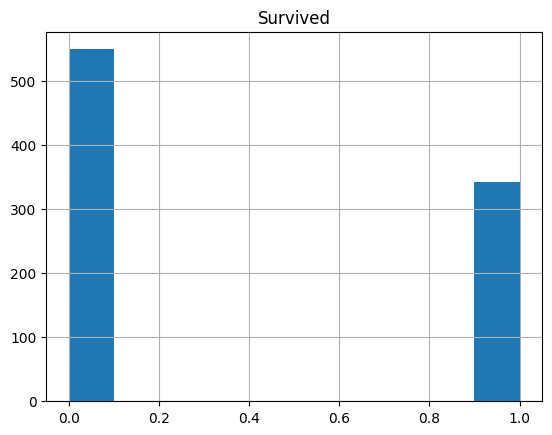

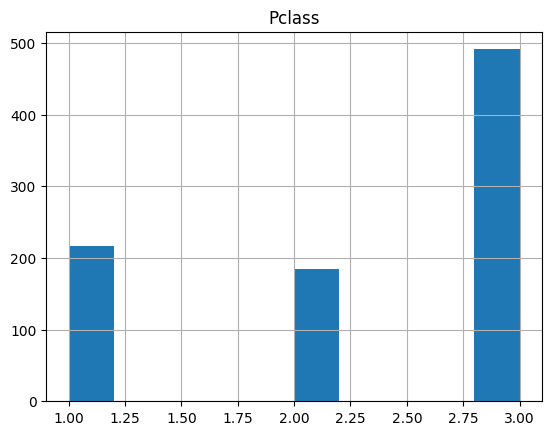

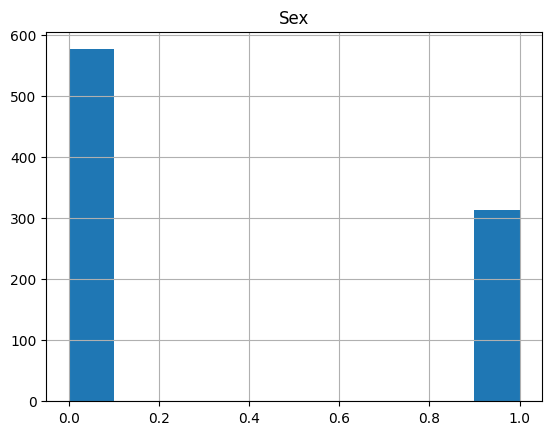

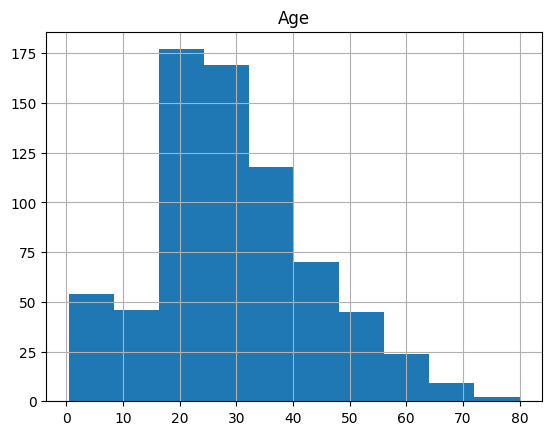

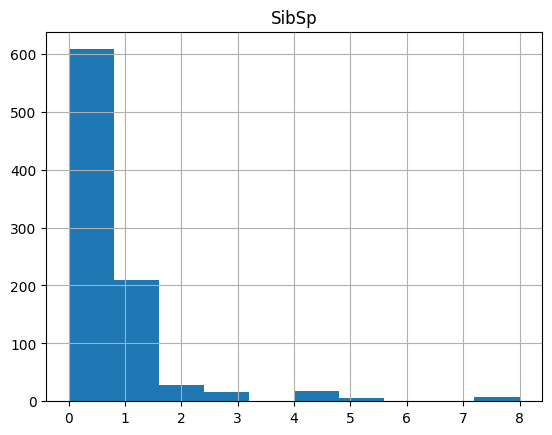

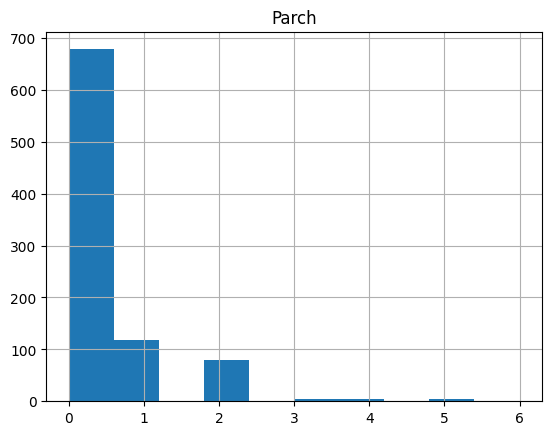

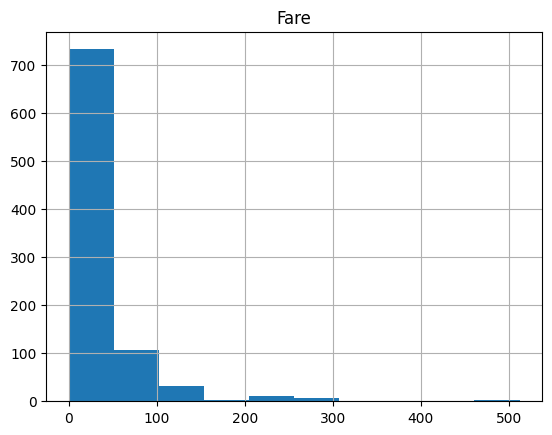

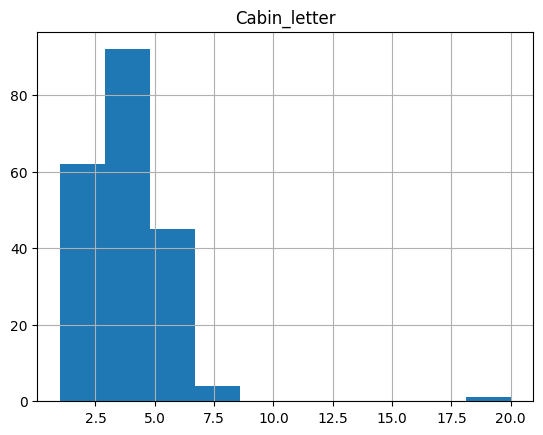

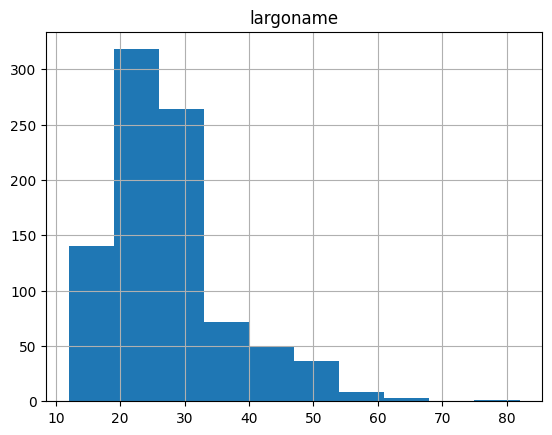

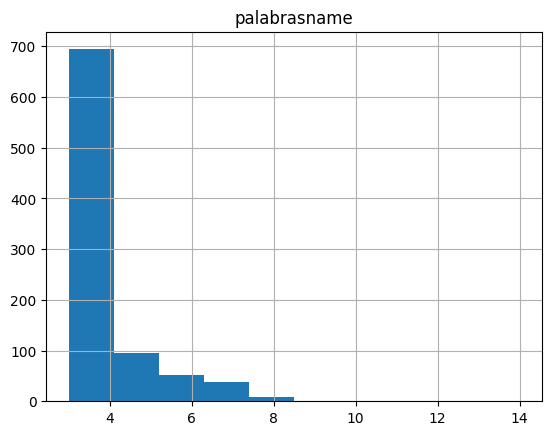

In [164]:
for i in df:
  if df[i].dtype.kind == "O":
    print(i,'\n', df[i].value_counts(), '\n')
  elif (df[i].dtype.kind=="f") or (df[i].dtype.kind=="i"):
    print(df.hist(i))

## Imputar valores en nulos

Algunas de las estrategias mas comunes:
* Imputar valor outlier (-999, 'Unknown')
* Imputar media en numericos
* Imputar moda en categoricos
* Imputar 0

In [165]:
df.isnull().sum()

Survived          0
Pclass            0
Sex               0
Age             177
SibSp             0
Parch             0
Fare              0
Embarked          2
Cabin_letter    687
largoname         0
palabrasname      0
dtype: int64

In [166]:
df["Cabin_letter"].fillna(-999, inplace=True)

In [167]:
df["Embarked"].fillna("unknown", inplace=True)

In [168]:
df["Age"].fillna(-999, inplace=True)

## Encoding categoricos

3 opciones:
* Si tienen un sentido ordinal -> convertir a numerico.
* Si tienen un sentido cardinal:
  * 2 posibles categorias -> indicador booleano
  * más de 2 categorias -> One-Hot-Encoding

In [169]:
df=pd.get_dummies(data=df ,columns=["Embarked"])

In [170]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin_letter,largoname,palabrasname,Embarked_C,Embarked_Q,Embarked_S,Embarked_unknown
0,0,3,0,22.0,1,0,7.2500,-999.0,23,4,False,False,True,False
1,1,1,1,38.0,1,0,71.2833,3.0,51,7,True,False,False,False
2,1,3,1,26.0,0,0,7.9250,-999.0,22,3,False,False,True,False
3,1,1,1,35.0,1,0,53.1000,3.0,44,7,False,False,True,False
4,0,3,0,35.0,0,0,8.0500,-999.0,24,4,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,-999.0,21,3,False,False,True,False
887,1,1,1,19.0,0,0,30.0000,2.0,28,4,False,False,True,False
888,0,3,1,-999.0,1,2,23.4500,-999.0,40,5,False,False,True,False
889,1,1,0,26.0,0,0,30.0000,3.0,21,4,True,False,False,False


## Eliminar alta correlación

In [171]:
corr = df.corr()

In [172]:
corr.style.background_gradient(cmap='coolwarm')

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin_letter,largoname,palabrasname,Embarked_C,Embarked_Q,Embarked_S,Embarked_unknown
Survived,1.000000,-0.338481,0.543351,0.089941,-0.035322,0.081629,0.257307,0.316882,0.332350,0.276512,0.168240,0.003650,-0.155660,0.060095
Pclass,-0.338481,1.000000,-0.131900,-0.183331,0.083081,0.018443,-0.549500,-0.725246,-0.220001,-0.221348,-0.243292,0.221009,0.081720,-0.074282
Sex,0.543351,-0.131900,1.000000,0.052524,0.114631,0.245489,0.182333,0.140426,0.448759,0.375778,0.082853,0.074115,-0.125722,0.064296
Age,0.089941,-0.183331,0.052524,1.000000,-0.026309,0.118371,0.103554,0.151442,0.158555,0.153237,-0.032240,-0.337683,0.237399,0.025949
SibSp,-0.035322,0.083081,0.114631,-0.026309,1.000000,0.414838,0.159651,-0.040457,0.165019,0.141757,-0.059528,-0.026354,0.070941,-0.022508
Parch,0.081629,0.018443,0.245489,0.118371,0.414838,1.000000,0.216225,0.036986,0.252282,0.215977,-0.011069,-0.081228,0.063036,-0.022467
Fare,0.257307,-0.549500,0.182333,0.103554,0.159651,0.216225,1.000000,0.481691,0.155832,0.152981,0.269335,-0.117216,-0.166603,0.045646
Cabin_letter,0.316882,-0.725246,0.140426,0.151442,-0.040457,0.036986,0.481691,1.000000,0.190903,0.183475,0.208247,-0.129541,-0.109844,0.086878
largoname,0.332350,-0.220001,0.448759,0.158555,0.165019,0.252282,0.155832,0.190903,1.000000,0.922586,0.027481,-0.140941,0.062817,0.015517
palabrasname,0.276512,-0.221348,0.375778,0.153237,0.141757,0.215977,0.152981,0.183475,0.922586,1.000000,0.021336,-0.147658,0.072186,0.017567


In [173]:
del(df["palabrasname"])

## Eliminar mínima varianza

In [174]:
vt = VarianceThreshold(threshold = 0.01)
vt.fit(df)

cols_lowvar = df.columns[vt.get_support()==False]
cols_lowvar

Index(['Embarked_unknown'], dtype='object')

In [175]:
del(df["Embarked_unknown"])

# Split X-y

In [176]:
target = 'Survived'
features = df.columns[df.columns != target]

In [177]:
y = df[target]
X = df[features]

In [178]:
print('Target del modelo:', target)
print('Variables a utilizar en el modelo:', list(features))

Target del modelo: Survived
Variables a utilizar en el modelo: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin_letter', 'largoname', 'Embarked_C', 'Embarked_Q', 'Embarked_S']


# Target distribution

[]

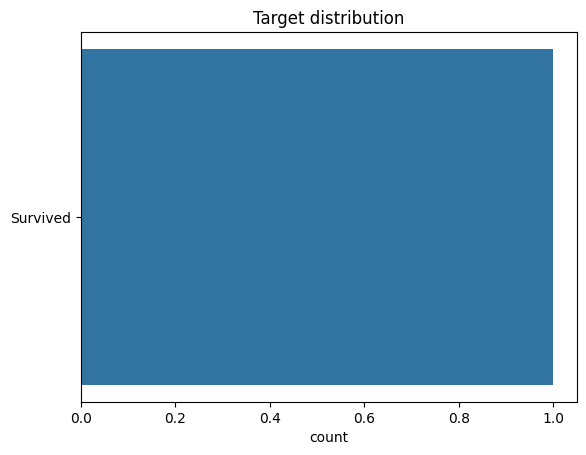

In [179]:
sns.countplot(target)
plt.title('Target distribution')
plt.plot()

# Split train-test (NO)

Como estamos en una competicion no sacrificaremos parte del dataset para TEST, haremos Cross-Validation para seleccionar el mejor modelo.

In [180]:
X_train = X
y_train = y

# Rescaling

Definimos el scaler en el train (.fit_transform).

In [181]:
# Estandarización: fit_transform() en train, transform() en test
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)# restar la media y dividar por la varianza?


X_train_std = pd.DataFrame(X_train_std, columns = X_train.columns, index= X_train.index)


In [182]:
X_train.head(3)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin_letter,largoname,Embarked_C,Embarked_Q,Embarked_S
0,3,0,22.0,1,0,7.2500,-999.0,23,False,False,True
1,1,1,38.0,1,0,71.2833,3.0,51,True,False,False
2,3,1,26.0,0,0,7.9250,-999.0,22,False,False,True


In [183]:
X_train_std.head(3)

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin_letter,largoname,Embarked_C,Embarked_Q,Embarked_S
0,0.827377,-0.737695,0.478896,0.432793,-0.473674,-0.502445,-0.544924,-0.427451,-0.482043,-0.307562,0.619306
1,-1.566107,1.355574,0.517860,0.432793,-0.473674,0.786845,1.834040,2.590962,2.074505,-0.307562,-1.614710
2,0.827377,1.355574,0.488637,-0.474545,-0.473674,-0.488854,-0.544924,-0.535252,-0.482043,-0.307562,0.619306


# TRAIN MODEL

## Model competition

* Prueba distintos modelos de https://scikit-learn.org/stable/modules/classes.html
y mide su performance con Cross Validation.
* Para ello utiliza la funcion evaluate_classification() para registrar los resultados del benchmark de modelos.

In [184]:
modelos=[LogisticRegression(),RandomForestClassifier(),XGBClassifier(),LGBMClassifier(),KNeighborsClassifier()]
for i in modelos:
  model=i
  model.fit(X_train, y_train)
  modelcomp=evaluate_classification(model, X_train,y_train)
#modelcomp.drop_duplicates(inplace = True)

[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 280
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 280
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info

In [185]:
modelcomp

,Model,AUC Train,AUC Cross-Valida
3,LGBMClassifier(),0.998903,0.866256
1,RandomForestClassifier(),0.999965,0.862359
2,"XGBClassifier(base_score=None, booster=None, c...",0.999656,0.851481
0,LogisticRegression(),0.848899,0.843731
4,KNeighborsClassifier(),0.879259,0.716595


## Hyperparameter tuning

La hiperparametrización puede ser costosa sino acotamos lo suficiente el abanico de posibles valores. Como consejo, centrarse en hiperparametrizar los primeros valores que aparecen dentro de la funcion del algoritmo, suelen ser los más determinantes, y no dejar de consultar la documentacion para entender que posibles valores adopta cada parametro.

In [186]:
parametros = {
  'num_leaves': list(range(10, 100, 10)),
    'max_depth': [5, 10, 15],
    'lambda_l1': [0, 0.1, 0.5, 1],
    'lambda_l2': [0, 0.1, 0.5, 1],
    'subsample': [0.5, 0.8, 1],
    'feature_fraction': [0.5, 0.8, 1],
    'min_child_samples': [10, 50, 100]
}

In [187]:
search_hp = RandomizedSearchCV(estimator=LGBMClassifier(),
                               param_distributions = parametros,
                               scoring='roc_auc',
                               cv = 4,                                    # numero de folds para cross-validation
                               n_iter = 50,                               # numero de iteraciones, cada una testeara una configuracion distinta
                               n_jobs=-1,
                               verbose=True)

In [188]:
search_hp.fit(X_train_std, y_train);

Fitting 4 folds for each of 50 candidates, totalling 200 fits
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

In [189]:
print("---- Results from Random Search -----" )
print("\n The best estimator across ALL searched params:", search_hp.best_estimator_)
print("\n The best AUC_ROC:", search_hp.best_score_)
print("\n The best parameters across ALL searched params:\n", search_hp.best_params_)

---- Results from Random Search -----

 The best estimator across ALL searched params: LGBMClassifier(feature_fraction=1, lambda_l1=1, lambda_l2=0.1, max_depth=10,
               min_child_samples=50, num_leaves=90, subsample=0.8)

 The best AUC_ROC: 0.8721447859327947

 The best parameters across ALL searched params:
 {'subsample': 0.8, 'num_leaves': 90, 'min_child_samples': 50, 'max_depth': 10, 'lambda_l2': 0.1, 'lambda_l1': 1, 'feature_fraction': 1}


## Final model

Como hemos aplicado hiperparametrizacion, el modelo sera el resultado del proceso (si conseguimos mejorar a la parametrización por default).



In [190]:
best_model = search_hp.best_estimator_

# PREDICT FOR SUBMISSION

Para hacer el submit de los datos en la competicion, tenemos que hacer un predict sobre el dataset 'titanic_test.csv'.

In [191]:
X_pred = pd.read_csv('titanic/test.csv')

X_pred.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Model features

In [ ]:
features_model =  list(best_model.feature_name_)
print('Estas son las variables que tenemos que conseguir en el preprocessing para que el modelo funcione:\n', features_model)

## ML Preprocessing

Se deben acometer las mismas transformaciones que las realizadas en el preprocessing del train data:
* Generacion de nuevas variables
* Imputación de nulos (mismos valores)
* One Hot Encoding
* Drop de columnas
<br><br>
No repetimos:
* Analisis exploratorio
* Analisis de altas correlaciones
* Analisis de baja varianza

In [192]:
# Primera letra cabina
X_pred['Cabin_letter'] = X_pred['Cabin'].str[0]

In [193]:
map_values = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
    'T': 20
}

X_pred['Cabin_letter'] = X_pred['Cabin_letter'].map(map_values)

In [194]:
# Longitud nombre
X_pred["largoname"]=X_pred['Name'].str.len()

In [195]:
del(X_pred["PassengerId"])

In [196]:
del(X_pred["Cabin"])

In [197]:
del(X_pred["Ticket"])

In [198]:
del(X_pred["Name"])

In [199]:
X_pred=X_pred.replace({"male":0,"female":1})

In [200]:
X_pred["Cabin_letter"].fillna(-999, inplace=True)

In [201]:
X_pred["Embarked"].fillna("unknown", inplace=True)

In [202]:
X_pred["Age"].fillna(-999, inplace=True)

In [205]:
X_pred=pd.get_dummies(data=X_pred ,columns=["Embarked"])

## Check model features

Check de variables. Las variables del dataset para PREDICT deben coincidir con las variables utilizadas en el entrenamiento.

In [206]:
features_test = list(X_pred.columns)

print('Columnas en dataset:',len(features_test))
print('Variables en modelos:',len(features_model))
print('¿Match?:', features_model == features_test)

Columnas en dataset: 11
Variables en modelos: 11
¿Match?: True


In [207]:
missing_features = [i for i in features_model if i not in features_test]
print('Variables que faltan el el dataset:\n', missing_features)

Variables que faltan el el dataset:
 []


In [208]:
for col in missing_features:
  X_pred[col]= 0

In [209]:
drop_features = [i for i in features_test if i not in features_model]
print('Variables que debes eliminar de tu dataset:\n', drop_features)

Variables que debes eliminar de tu dataset:
 []


In [210]:
X_pred.drop(columns = drop_features, inplace=True)

In [211]:
features_test = list(X_pred.columns)

print('Columnas en dataset:',len(features_test))
print('Variables en modelos:',len(features_model))
print('¿Match?:', features_model == features_test)

Columnas en dataset: 11
Variables en modelos: 11
¿Match?: True


In [212]:
# Reordena variables
X_pred = X_pred[features_model]

## Rescaling

Aplicamos mismo scaler que en el training (".transform", no hacer ".fit")

In [213]:
X_train_std = scaler.transform(X_pred)# restar la media y dividar por la varianza?

## Predictions

In [214]:
predictions = best_model.predict(X_pred)[0]

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


# Upload predictions to Kaggle.com

Se deben subir las predicciones en un .csv con 2 columnas (PassengerId, Survived) en el apartado de submissions en https://www.kaggle.com/competitions/titanic/data. Debe contener 418 rows + header.

In [ ]:
submission = pd.DataFrame(predictions, columns=['Survived'], index = X_pred.index)

In [ ]:
submission.to_csv('titanic/predictions.csv')